# Earth2MIP Demo - Custom Datasets

**Installation**

* [apex](https://github.com/NVIDIA/apex#quick-start)

In [1]:
import numpy as np
import cdsapi
from pathlib import Path
import xarray as xr
import autoroot
import datetime
from earth2mip import inference_ensemble, registry
from earth2mip.networks import get_model
from earth2mip.initial_conditions import cds
from earth2mip.inference_ensemble import run_basic_inference
import matplotlib.pyplot as plt
from bayesevt._src.data.ics import LocalDataSourceXArray

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Model

First, we need to select a model.
This will depend on what you choose to install. 
I personally chose the `FourCastNet` model because it is the most flexible in terms of resolution (in theory). 
But in principal, we could choose other models but it would depend on the variables.

In [2]:
model_name = "fcnv2_sm" 

We have Get channel names without saving the model

In [3]:
from bayesevt._src.models.earth2mip import EARTH2MIP_MODEL_VARIABLES

channel_names = EARTH2MIP_MODEL_VARIABLES["fcnv2_sm"]
channel_names = EARTH2MIP_MODEL_VARIABLES[model_name]

First, we need to load the model and put it to some processor, either `cpu` or some `cuda:x` device.

**Warning**: CPU is very slow even for inference.
It's not recommended.

In [4]:
model = f"e2mip://{model_name}"
device = "cuda:1"

We initialize a special `earth2mip.networks.Inference` datastructure which has a host of different features for making predictions.
The most important thing is initializing a model from their registry or a custom model. 
And of course the device

In [5]:
time_loop  = get_model(
    model=model,
    device=device,
)

In [6]:
channel_names = time_loop.in_channel_names
# channel_names

***

## Initial Condition

We need to do an initial condition to propagate the data forward.
We will use a special `dataclass` which defines all of the parameters we need to load data from an `xarray.Dataset`.
This should include `.netcdf`, `.grib`, and `.grib`. 
As long as we can define the xarray engine and it follows some standards, we should be able to load it.

**Parameters**

* `t0` - `datetime` object with a time period.
* `num_steps` - the number of time steps (6h intervals)

In [4]:
# starting timestep
t0 = datetime.datetime(2021,8,1)

# number of forecast steps
num_steps = 10 # 6h intervals

## Custom Datasets

### NETCDF Files

Our first example will have a custom `.netcdf` file where we already have the variables available.

In [5]:
file_paths = [
    "/pool/proyectos/CLINT/sa4attrs/data/raw/reanalysis-202108010000-sl.nc",
    "/pool/proyectos/CLINT/sa4attrs/data/raw/reanalysis-202108010000-pl.nc",
]

In [8]:
save_name = "reanalysis_20180715_20180830_ics_v2"

file_paths = [
    f"/pool/proyectos/CLINT/sa4attrs/data/raw/events/{save_name}.nc"
]

In [6]:
ds = xr.open_mfdataset(file_paths, combine="by_coords", engine="netcdf4")
ds

<xarray.Dataset> Size: 357MB
Dimensions:    (longitude: 1440, latitude: 721, time: 1, level: 13)
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 8B 2021-08-01
  * level      (level) int32 52B 100 200 1000 300 400 50 ... 150 600 250 700 925
Data variables: (12/14)
    msl        (time, latitude, longitude) float32 4MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    u100       (time, latitude, longitude) float32 4MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 4MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 4MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 4MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 4MB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ...         ...
    t          (time, level, latitude, longitude) float32 54MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    z          (time, level, latitude, longitude) float32 54MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 54MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 54MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    r          (time, level, latitude, longitude) float32 54MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 54MB dask.array<chunksize=(1, 13, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-02-24 03:48:12 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

#### Parameters

We have some key parameters we need to set when dealing with this dataset.

**Name Convention**.
The name convention follows the *full name*, e.g., "10m_u_component_of_wind". This convention is set by the CDS.
We have a database within the library for all variables that are related to the AI models so it will recognize all names and do the translation even though we provided a list of `channel_names` which have the short form format.

**Pressure Name**.
We need to specify what is the pressure level name. 
This varies across datasets so the user can manually specify it to match theirs.

**Engine**.
We use the native `xarray.open_mfdataset(..., engine=...)` function.
So we are free to specify whichever engine that is our dataset format.
Even though this example uses `.netcdf`, we are also compatible with whichever formats are available.

In [7]:
# initial condition
data_source_xr = LocalDataSourceXArray(
    channel_names=channel_names,
    file_paths=file_paths,
    pressure_name="level", 
    name_convention="short_name",
    engine="netcdf4", 
    
)

In [8]:
out_xr = data_source_xr[t0]

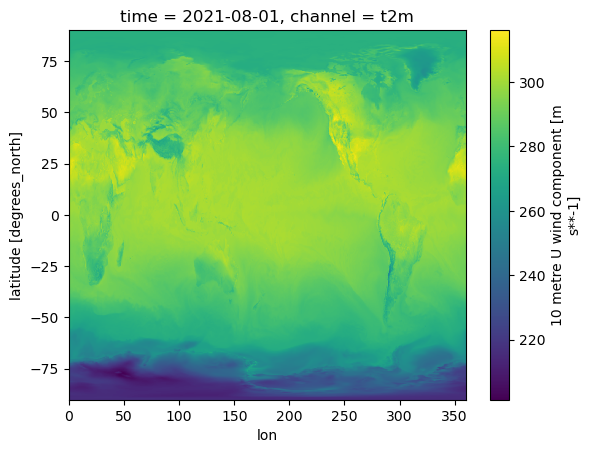

In [9]:
out_xr.sel(channel="t2m").plot()

### GRIB Files

The next example is a `.grib` file.

In [13]:
file_paths = [
    "/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_pl_20210801.grib",
    "/pool/proyectos/CLINT/sa4attrs/data/raw/fcnv2sm_sl_20210801.grib"
]

In [14]:
ds = xr.open_mfdataset(file_paths, combine="by_coords", engine="cfgrib")
ds

<xarray.Dataset> Size: 303MB
Dimensions:        (latitude: 721, longitude: 1440, isobaricInhPa: 13)
Coordinates:
    number         int64 8B 0
    time           datetime64[ns] 8B 2021-08-01
    step           timedelta64[ns] 8B 00:00:00
    surface        float64 8B ...
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    valid_time     datetime64[ns] 8B 2021-08-01
  * isobaricInhPa  (isobaricInhPa) float64 104B 1e+03 925.0 850.0 ... 100.0 50.0
Data variables: (12/13)
    sp             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    tcwv           (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    msl            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u10            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    v10            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    t2m            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    ...             ...
    v100           (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    z              (isobaricInhPa, latitude, longitude) float32 54MB dask.array<chunksize=(13, 721, 1440), meta=np.ndarray>
    t              (isobaricInhPa, latitude, longitude) float32 54MB dask.array<chunksize=(13, 721, 1440), meta=np.ndarray>
    u              (isobaricInhPa, latitude, longitude) float32 54MB dask.array<chunksize=(13, 721, 1440), meta=np.ndarray>
    v              (isobaricInhPa, latitude, longitude) float32 54MB dask.array<chunksize=(13, 721, 1440), meta=np.ndarray>
    r              (isobaricInhPa, latitude, longitude) float32 54MB dask.array<chunksize=(13, 721, 1440), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-02-25T11:49 GRIB to CDM+CF via cfgrib-0.9.1...

#### Parameters


This is a bit trickier to handle but it can be handled via the `xarray` API.
Some key point are we need to change some of the parameters which are different than the previous ones.

**Pressure Name**. 
We see that we have the ECMWF standard of `isobaricInhPa` so we specify that instead.

**Name Convention**.
We see that we have the standard ECMWF `short_name` format. 

**Engine**.
We are using `.grib` files so we need to specify this as the backend for xarray.


**Note**:
In addition, this is a spatial field with no time dimension.
However even though we did not specify the time, it's still will still read it and assume that it is the first time step.

In [15]:
# initial condition
data_source_xr = LocalDataSourceXArray(
    channel_names=channel_names,
    file_paths=file_paths,
    pressure_name="isobaricInhPa", 
    name_convention="short_name",
    engine="cfgrib", 
    
)

In [16]:
out_xr = data_source_xr[t0]

In [25]:
out_xr

<xarray.DataArray 'u10' (channel: 73, lat: 721, lon: 1440)> Size: 303MB
dask.array<getitem, shape=(73, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B 0
    time        datetime64[ns] 8B 2021-08-01
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B ...
  * lat         (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    valid_time  datetime64[ns] 8B 2021-08-01
  * channel     (channel) <U5 1kB 'u10m' 'v10m' 'u100m' ... 'r925' 'r1000'
  * lon         (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes: (12/30)
    GRIB_paramId:                             165
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           10u
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            unknown

In [34]:
# out_xr.assign_coords({"lat": ds.lat, "lon": ds.lon})
out_xr.drop_indexes("channel").assign_coords({"lat": ds.lat, "lon": ds.lon})

<xarray.DataArray 'u10' (channel: 73, lat: 721, lon: 1440)> Size: 303MB
dask.array<getitem, shape=(73, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B 0
    time        datetime64[ns] 8B 2021-08-01
    step        timedelta64[ns] 8B 00:00:00
    surface     float64 8B ...
    valid_time  datetime64[ns] 8B 2021-08-01
    channel     (channel) <U5 1kB 'u10m' 'v10m' 'u100m' ... 'r925' 'r1000'
  * lat         (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon         (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes: (12/30)
    GRIB_paramId:                             165
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           10u
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                10 metre U wind component
    units:                                    m s**-1
    standard_name:                            unknown

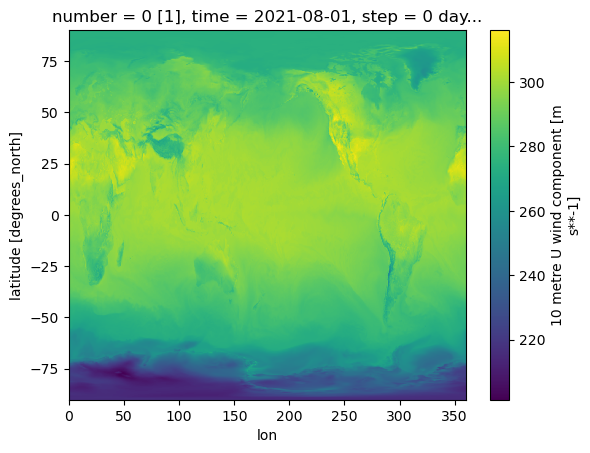

In [17]:
out_xr.sel(channel="t2m").plot()

## Inference Loop

These are the same steps as the previous tutorial.

In [18]:
%%time
ds = run_basic_inference(
    time_loop, 
    n=num_steps, 
    data_source=data_source_xr, 
    time=t0
)

CPU times: user 8.71 s, sys: 3.73 s, total: 12.4 s
Wall time: 12.8 s


In [19]:
ds.chunk()

<xarray.DataArray (time: 11, history: 1, channel: 73, lat: 721, lon: 1440)> Size: 3GB
dask.array<xarray-<this-array>, shape=(11, 1, 73, 721, 1440), dtype=float32, chunksize=(11, 1, 73, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * channel  (channel) <U5 1kB 'u10m' 'v10m' 'u100m' ... 'r850' 'r925' 'r1000'
  * time     (time) datetime64[ns] 88B 2021-08-01 ... 2021-08-03T12:00:00
Dimensions without coordinates: history

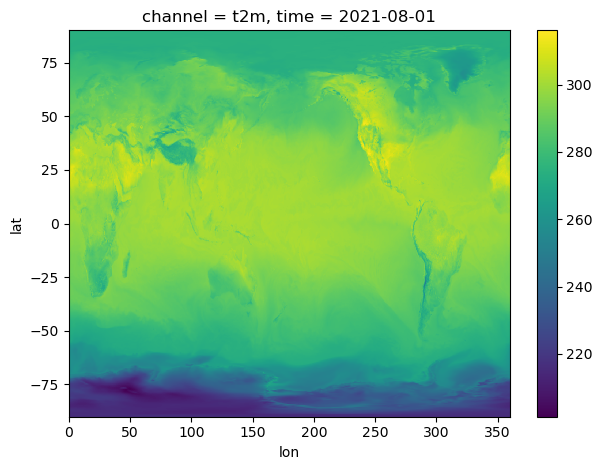

In [20]:
fig, ax = plt.subplots()
ds.sel(channel="t2m").isel(time=0).squeeze().plot.pcolormesh(ax=ax)
plt.tight_layout()
plt.show()

## Compare: CDS Dataset

We will compare this with the previous dataset with one we can call online. 
In theory, it should be the exact same dataset but we are going to download it from the CDS.

In [21]:
# initial condition
data_source_cds = cds.DataSource(time_loop.in_channel_names)

In [22]:
%%time
ds_cds = run_basic_inference(
    time_loop, 
    n=num_steps, 
    data_source=data_source_cds, 
    time=t0
)

CPU times: user 4.18 s, sys: 7.85 s, total: 12 s
Wall time: 12.1 s


In [23]:
ds_cds.chunk()

<xarray.DataArray (time: 11, history: 1, channel: 73, lat: 721, lon: 1440)> Size: 3GB
dask.array<xarray-<this-array>, shape=(11, 1, 73, 721, 1440), dtype=float32, chunksize=(11, 1, 73, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * channel  (channel) <U5 1kB 'u10m' 'v10m' 'u100m' ... 'r850' 'r925' 'r1000'
  * time     (time) datetime64[ns] 88B 2021-08-01 ... 2021-08-03T12:00:00
Dimensions without coordinates: history

Below, we calculate the difference between the two fields: 
1. field 1 generated by data we downloaded manually and saved
2. field 2 generated by data we downloaded via the CDSAPI

We will check to make sure all variables are the same across all time steps.

In [24]:
np.abs(ds - ds_cds).mean().values

array(0., dtype=float32)